In [1]:
# cell magic functions :
#   `%%capture` blocks jupyter notebook output,
#   `%%script false --no-raise-error` avoid cell execution


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta #Date arithmetic
import mplfinance as mpf

#import PIL
#print('Pillow Version:', PIL.__version__)

# load and show an image with Pillow
from PIL import Image

import h5py
import os
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import time

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



2.2.0
Num GPUs Available:  1


In [5]:
import numpy as np
def calcArrayMemorySize(s):
    return "Memory size is : " + str(s.nbytes/1024/1024) + " Mb"
    
print(calcArrayMemorySize(np.random.randint(0,255,size=(10,64,64,3))))
print(calcArrayMemorySize(np.random.random(size=(10,64,64,3))))
print(calcArrayMemorySize(np.random.random_sample(size=(10,64,64,3))))



Memory size is : 0.9375 Mb
Memory size is : 0.9375 Mb
Memory size is : 0.9375 Mb


Memory size is : 9.375 Mb
Memory size is : 9.375 Mb
Memory size is : 9.375 Mb


In [15]:
np.random.random_sample()

Memory size is : 9.375 Mb
Memory size is : 9.375 Mb


In [9]:

calcArrayMemorySize(arr)

'Memory size is : 9.375 Mb'

In [2]:
DATE_WINDOW = 20
#NO_OF_IMAGES = 10000
UP_THRESHOLD_PCT = 1
DOWN_THRESHOLD_PCT = 1
IMG_SIZE = 64

def fn_setTarget(val):
    if val > UP_THRESHOLD_PCT: out = 2
    elif val < -DOWN_THRESHOLD_PCT: out = 1
    else: out = 0
    return out

* Use pandas_datareader for reading stock prices for various APIs
    + [This article is uses Google/Yahoo API which is no longer supports](https://learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/)
    + [Uses Yahoo API but it didnt work for me](https://medium.com/@jouneidraza522/yahoo-finance-api-to-get-stocks-tickers-data-in-python-c49820249a18)

* [Uses free financial API Financialmodelingprep and plotly. CHECK IT OUT](https://towardsdatascience.com/python-stock-analysis-candlestick-chart-with-python-and-plotly-e619143642bb)

* [yfinance package CHECK IT](https://aroussi.com/post/python-yahoo-finance)

* ['matplotlib.finance' module is deprecated. Did not work](https://pythonprogramming.net/candlestick-ohlc-graph-matplotlib-tutorial/)

* Load stock data from CSV and then plot Candlestick
    + [Plotly Candlestick charts - Saving Images is complicated](https://plotly.com/python/candlestick-charts/)
    + [USED HERE : new mplfinance package](https://pypi.org/project/mplfinance/)
    
    

### Misc notes
* If you are going to do a lot of selections by date, it may be quicker to set the date column as the index first. Then you can select rows by date using df.loc[start_date:end_date].

* The plot was cleaned up using rcParams dict of matplotlib. This article was useful https://github.com/matplotlib/mplfinance/issues/48
* All the rcParams are towards the end of this https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html#customizing-with-matplotlibrc-files

* Creating a new column using UDF fn_setTarget `df['Prev_Close'] = (((df['Close'] / df['Close'].shift(1)) - 1) * 100).apply(fn_setTarget)`

* Append to array and extract only the value from the DF and not the index `target_arr.append(data[-1:]['Target'].item())`

* Last 5 rows : `df[-5:]`
* Everthing other than last 5 rows : `df[:-5]`

* Image Manipulation
    + https://realpython.com/storing-images-in-python/
    + https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

In [3]:
#Without parse_date, date column is typed as Object
#df['date'] = df['date'].astype('datetime64')
#Also, could have used pd.to_datetime()
# Also : df.index.name = 'Date'
df = pd.read_csv("./data/asx_03Jul20.csv",parse_dates=[1]) #,index_col=1)
#print(df.head())


In [4]:
# Rename cols needed for next steps ?
df.columns = ['Symbol','Date','Open','High','Low','Close','Volume','Adjusted']
df = df[df['Close'] > 0]
#print(df.info())
max_date = df.index.max()

In [5]:
#Compute Growth and Target column
df['Close_Prev'] = df.groupby(['Symbol'])['Close'].shift(1)
df = df[df['Close_Prev'] > 0]
df['Target'] = (100 * ((df['Close']/df['Close_Prev']) - 1)).apply(fn_setTarget)
#df.groupby(['Target'])['Target'].count()


In [6]:
%%script false --no-raise-error


# Rows per symbols
df.groupby(['Symbol'])['Symbol'].count()


In [7]:
# Core function that creates the plot and saves to a file

def save_candlestick(data,index):
        
    # To set a datetime as an index
    data = data.set_index(pd.DatetimeIndex(data['Date'])) 
   
    #Create custom styles
    mc = mpf.make_marketcolors(up='g',down='r')
    rc = {'xtick.major.bottom':False
        ,'ytick.major.left':False
        ,'xtick.major.size':0,'ytick.major.size':0
        ,'axes.labelsize' : 0
        ,'savefig.jpeg_quality' : 5
        ,'savefig.bbox':'tight'
        ,'patch.linewidth' : 0 #candle border
        ,'lines.linewidth' : 1.5 #wick width
        ,'axes.spines.left' :False #plot border
        ,'axes.spines.top' :False
        ,'axes.spines.bottom' :False
        ,'axes.spines.right' :False
        }
    s  = mpf.make_mpf_style(marketcolors=mc,rc = rc)
    
    # First we set the kwargs that we will use for all of these examples:
    kwargs = dict(type='candle',volume=False,figratio=(5,5),figscale=1)
    #mpf.plot(data,**kwargs,style = s,savefig='data/images/fig'+ str(index) +'.png')
    #mpf.plot(data,**kwargs,style = s,savefig=r'data/temp_image.png')
    mpf.plot(data,**kwargs,style = s,savefig='data/temp_image'+ str(index) +'.png')
    #time.sleep(1)
    

In [8]:
data_grouped = df.groupby('Symbol')
for name,group in data_grouped:    
    print(name + '  ' + str(group['Symbol'].count()))

A2M.AX  1331
AGL.AX  3917
ALL.AX  3917
ALQ.AX  3917
ALU.AX  3708
ALX.AX  2637
AMC.AX  3917
AMP.AX  3917
ANN.AX  3917
ANZ.AX  3917
APA.AX  3916
APT.AX  762
AST.AX  3676
ASX.AX  3917
AWC.AX  3917
AZJ.AX  2427
BEN.AX  3917
BHP.AX  3917
BLD.AX  3915
BOQ.AX  3917


In [9]:
%%script false --no-raise-error

# Function that will be called by multiprocessing 
# Separate process will spawned for each Symbol

# First attempt was creating set_x_sub as a list but later settled with single array containing both x and y ie set_xy

def inner_loop(group):
    print("inside")
    
    loop_range=  (group['Symbol'].count()) -  (DATE_WINDOW) - 10
    #loop_range = 5
    fname = group[-1:]['Symbol'].item()
    #set_x_sub = [] #np.empty(shape=(NO_OF_IMAGES,IMG_SIZE,IMG_SIZE,4))
    #set_y_sub = []

    #set_x_sub = np.empty(shape=(loop_range,IMG_SIZE,IMG_SIZE,3))
    #set_y_sub = np.empty(shape=(loop_range),dtype = 'int64')

    set_xy = (np.empty(shape=(loop_range),dtype = 'int64')
            ,np.empty(shape=(loop_range,IMG_SIZE,IMG_SIZE,3)))

    for i in range(loop_range):    
        #print("Iter:" + str(i))    
        #Save the Target value of the last row as this will be the predicted value
        #target_arr.append(data[-1:]['Target'].item())
        #set_y_sub.append(group[-1:]['Target'].item())
        
        #set_y_sub[i] = group[-1:]['Target'].item()

        set_xy[0][i] = group[-1:]['Target'].item()

        #Remove the last row and plot
        group = group[:-1]        
      
        #Read the saved image and convert it into numpy after resizing
        save_candlestick(group[-DATE_WINDOW:],fname)

        img_asNumpy = np.array(Image.open('data/temp_image'+ fname +'.png').resize((IMG_SIZE,IMG_SIZE)))
        
        #image_without_alpha 
        img_asNumpy = img_asNumpy[:,:,:3]
        #set_x_sub.append(img_asNumpy)    

        #set_x_sub[i] = img_asNumpy

        set_xy[1][i] = img_asNumpy
    
    #out = {"set_y": set_y_sub,"set_x": set_x_sub}
    #return out
    #return [set_y_sub,set_x_sub]
    return set_xy
    


   

In [10]:
# Function that separates x and y
# And also created .h5 files to save the arrays
def createXY(result,fname):
    first = [x for (x,y) in result]
    set_y = np.concatenate(first,axis =0)

    second = [y for (x,y) in result]
    set_x = np.concatenate(second,axis =0)

    print(fname)

    file = h5py.File("data/" + fname + ".h5", "w")
    file.create_dataset('set_x', data=set_x)
    file.create_dataset('set_y', data=set_y)
    file.close()


In [11]:
%%script false --no-raise-error

#Loop through an array one batch at a time
syms = df['Symbol'].unique()
print(len(syms))
for i in range(0,len(syms),3):
    print(i)
    print(syms[i:i+3])



### Multiprocessing function .. take long time

In [12]:
%%script false --no-raise-error

#Multiprocessing with batch of Symbols
start_time = time.time()
print(start_time)
import multiprocessing as mp
def applyParallel(dfGrouped, func):
    with mp.Pool(processes = 24) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    p.close()    
    #p.join()    
    return ret_list
    #return pd.concat(ret_list)

#data = df[df['Symbol'].isin(['A2M.AX','AGL.AX'])]
# data = df

for i in range(0,len(syms),3):
    print(syms[i:i+3])
    start_time = time.time()
    data = df[df['Symbol'].isin(syms[i:i+3])]
    data_grouped = data.groupby('Symbol')
    print(data_grouped['Symbol'].unique())
    result = applyParallel(data_grouped, inner_loop)

    print("Length of result = " +  str(len(result)))
    createXY(result,"Set" + str(i))
    print("--- %s seconds ---" % (time.time() - start_time))

#print(np.array(result).shape)
#--- 1407.3019680976868 seconds ---



In [13]:
%%script false --no-raise-error

# Test saved file reading
file = h5py.File("data/Set0.h5", "r")
set_x = file["set_x"][:]
set_y = file["set_y"][:]
file.close()



In [2]:
# Reads .h5 files
# Appends them to a list
# Finally converts the list to np

set_x = []
set_y = []
import os
for file in os.listdir("data/"):
    if file.endswith(".h5"):
        fname = os.path.join("data", file)
        file = h5py.File(fname, "r")
        set_x_temp = file["set_x"][:]
        set_y_temp = file["set_y"][:]

        set_x.append(set_x_temp)
        set_y.append(set_y_temp)


        file.close()

# Since set_x and set_y are list of arrays, use np.concatenate()
# Better than result_array = np.array(result) ?

set_x = np.concatenate(set_x,axis=0)
set_y = np.concatenate(set_y,axis=0)

In [3]:
#Normalise X
set_x = set_x/255.


#One hot encode Y
#set_y = tf.keras.utils.to_categorical(set_y)

print(set_x.shape)
print(set_y.shape)


(64889, 64, 64, 3)
(64889,)


In [4]:
values, counts = np.unique(set_y, axis=0, return_counts=True)
print(values)
print(counts)

# into a dict for presentation
#{tuple(a):b for a,b in zip(values, counts)}



[0 1 2]
[33882 15019 15988]


In [5]:
print(set_x.shape)
print(set_y.shape)

(64889, 64, 64, 3)
(64889,)


In [26]:
# Alternate train test split

m = set_x.shape[0]                  # number of training examples

#train_pct_index = int(0.8 * len(X))
train_pct_index = np.random.randint(m, size= (m * 80)//100)

#train_set_x, test_set_x = set_x[train_pct_index,:,:,:], set_x[~train_pct_index:,:,:,:]
#train_set_y, test_set_y = set_y[:train_pct_index], set_y[~train_pct_index:]

len(train_pct_index)



51911

In [37]:
m = set_x.shape[0]                  # number of training examples

#Shuffle X and Y ?
#permutation = list(np.random.permutation(m))
#set_x = set_x[permutation,:,:,:]
#set_y = set_y[permutation,:]
    
print(m)

#Split train/test
training_idx = np.random.randint(m, size= (m * 75)//100)
test_idx = np.random.randint(m, size= (m * 25)//100)
print(training_idx)
print(test_idx)

train_set_x, test_set_x = set_x[training_idx,:,:,:], set_x[test_idx,:,:,:]
train_set_y, test_set_y = set_y[training_idx], set_y[test_idx]


print(train_set_x.shape)
print(train_set_y.shape)
print(test_set_x.shape)
print(test_set_y.shape)


64889
[ 3078 28215  9127 ... 12096 53025 48458]
[45534 32335 35195 ... 34386 32356 35895]
(48666, 64, 64, 3)
(48666, 3)
(16222, 64, 64, 3)
(16222, 3)


In [6]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11345436357102224209
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3724767903229548254
physical_device_desc: "device: XLA_CPU device"
]


In [28]:
model = keras.Sequential([
    #keras.layers.Flatten(input_shape=(288, 432,3)),
    keras.layers.Flatten(input_shape=[64,64,3]),    
    keras.layers.Dense(512, activation='relu'),        
    keras.layers.Dense(64, activation='relu'),        
    keras.layers.Dense(3,activation='softmax')
])

model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               6291968   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 6,324,995
Trainable params: 6,324,995
Non-trainable params: 0
_________________________________________________________________


In [30]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.CategoricalCrossentropy(),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#model.fit(train_set_x, train_set_y, epochs=10)
history = model.fit(set_x, set_y, epochs=10) #,validation_split=0.2)


Epoch 1/10
Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f352e2ed040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 
2028/2028 [==============================] - 39s 19ms/step - loss: 1.0276 - accuracy: 0.5218
Epoch 2/10
 425/2028 [=====>........................] - ETA: 33s - loss: 1.0265 - accuracy: 0.5210

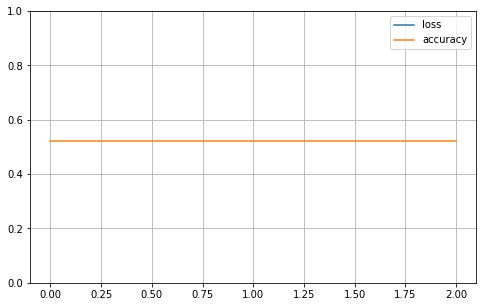

In [24]:
 
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True) 
plt.gca().set_ylim(0, 1) # set the vertical range to [ 0 - 1 ]
plt.show()


In [26]:
test_loss, test_acc = model.evaluate(test_set_x,  test_set_y, verbose=1)


33/33 [==============================] - 0s 2ms/step - loss: 1.0056 - accuracy: 0.5458


In [ ]:
#https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/

X = []
y = []

for features,label in image_data:
    X.append(features)
    y.append(label)

#print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

print(X[0])
print(y[0])



In [ ]:
#https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays
#https://realpython.com/storing-images-in-python/

import PIL
print('Pillow Version:', PIL.__version__)

# load and show an image with Pillow
from PIL import Image


In [ ]:
# Open the image form working directory
image = Image.open('data/images/fig5.png')
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)
# show the image
#load_image.show()



In [ ]:
from numpy import asarray

# convert image to numpy array
data = asarray(image)
print(type(data))
# summarize shape
print(data.shape)

#image_without_alpha = image[:,:,:3]
#print(data[:,:,:3])

In [ ]:
#Image resize
load_img_rz = np.array(Image.open('data/images/fig5.png').resize((200,200)))
Image.fromarray(load_img_rz).save('data/images/r_kolala.png')
print("After resizing:",load_img_rz.shape)


In [ ]:
#Crop
im = np.array(Image.open('data/images/fig5.png'))

print("Before trimming:",im.shape)

im_trim = im[100:250,10:260]
print("After trimming:",im_trim.shape)

Image.fromarray(im_trim).save('data/images/trim_kolala.png')

#print(im_trim)

In [ ]:
#https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


im = np.array(Image.open('data/images/fig5.png'))

print("Before trimming:",im.shape)



im_trim = crop_center(im,4,6)
print("After trimming:",im_trim.shape)

Image.fromarray(im_trim).save('data/images/trim_kolala.png')




### Old Code

In [ ]:
#Split train/test
training_idx = np.random.randint(m, size= (m * 75)//100)
test_idx = np.random.randint(m, size= (m * 25)//100)
print(training_idx)
print(test_idx)

train_set_x, test_set_x = set_x[training_idx,:,:,:], set_x[test_idx,:,:,:]
train_set_y, test_set_y = set_y[training_idx], set_y[test_idx]



In [ ]:
# Store inside HDF5 file
file = h5py.File("data/myData.h5", "w")
file.create_dataset('set_x', data=set_x)
file.create_dataset('set_y', data=set_y)
file.close()

# Read from the file
file = h5py.File("data/myData.h5", "r")
set_x = file["set_x"][:]
set_y = file["set_y"][:]
file.close()



In [ ]:
# Earlier attempt
# When result was a list of set_x and set_y
# Uses list comprehension
first = [x for (x,y) in result]
set_y = np.concatenate(first,axis =0)

second = [y for (x,y) in result]
set_x = np.concatenate(second,axis =0)



In [ ]:
# Earlier attempt when result was a list of set_x and set_y
# The entire result list was converted to array
# But the conversion was very slow (and got stuck)
result_array = np.array(result)

set_y = result_array[:,0,:]
set_y = set_y.reshape(150,).astype('int')
print(set_y.shape)

set_x_temp = result_array[:,1,:]
print(set_x_temp.shape)
#set_x_temp[1,1].shape
set_x = []
for i in range(set_x_temp.shape[0]):
    for j in range(set_x_temp.shape[1]):
        set_x.append(set_x_temp[i,j])
    
set_x = np.array(set_x)

set_x.shape




In [ ]:

# DID NOT WORK
#Try multithreading instead of multiprocessing

#Gave this error :
--> 393             self.figure.draw(self.renderer)
    394             # A GUI class may be need to update a window using this draw, so
    395             # don't forget to call the superclass.
    

start_time = time.time()
#import threading as mp
#import multiprocessing as mp
#from multiprocessing.pool import ThreadPool 
from multiprocessing.dummy import Pool as ThreadPool


def applyParallel(dfGrouped, func):
    pool = ThreadPool(20)
    ret_list = pool.map(func, [group for name, group in dfGrouped])
    pool.Close()
    pool.join()
    return ret_list
    
data = df[df['Symbol'].isin(['A2M.AX','AGL.AX','ALL.AX'])]
data_grouped = data.groupby('Symbol')
result = applyParallel(data_grouped, inner_loop)
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:

# First attempt to created the set_x array
# Loops through each Symbol at a time

start_time = time.time()
#data = df
data = df[df['Symbol'].isin(['A2M.AX','AGL.AX'])]

set_x = [] #np.empty(shape=(NO_OF_IMAGES,IMG_SIZE,IMG_SIZE,4))
set_y = []
data_grouped = data.groupby('Symbol')

flag_alternate = 0

for name,group in data_grouped:    
    print(name + '  ' + str(group['Symbol'].count()))

    loop_range=  (group['Symbol'].count()) -  (DATE_WINDOW) - 10
    print(loop_range)
    # No of images each group can have will be Row Count minus Window
    #for i in range(loop_range):
    for i in range(5):    
        #print("Iter:" + str(i))    
        #Save the Target value of the last row as this will be the predicted value
        #target_arr.append(data[-1:]['Target'].item())
        set_y.append(group[-1:]['Target'].item())
        
        #Remove the last row and plot
        group = group[:-1]
        
        
        #Read the saved image and convert it into numpy after resizing
        if flag_alternate == 0:
            save_candlestick(group[-DATE_WINDOW:],name)
            img_asNumpy = np.array(Image.open('data/temp_image0.png',mode='r').resize((IMG_SIZE,IMG_SIZE)))
            flag_alternate = 1
        else:
            save_candlestick(group[-DATE_WINDOW:],1)
            img_asNumpy = np.array(Image.open('data/temp_image1.png',mode='r').resize((IMG_SIZE,IMG_SIZE)))
            flag_alternate = 0
        
        #image_without_alpha 
        img_asNumpy = img_asNumpy[:,:,:3]
        set_x.append(img_asNumpy)    
    

print("--- %s seconds ---" % (time.time() - start_time))



In [ ]:

# Instead of saving the image, just store directly into array
    # In order to get the figure contents as RGB pixel values, the matplotlib.backend_bases.Renderer needs to first draw the contents of the canvas. You can do this by manually calling canvas.draw():
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
    from matplotlib.figure import Figure
    fig = Figure()
    canvas = FigureCanvas(fig)
    canvas.draw()       # draw the canvas, cache the renderer
    image = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    set_x.append(image)


In [ ]:
#If the Date column was not indexed
min_date = df['Date'][df['Date'].index.min()]
max_date = df['Date'][df['Date'].index.max()]
df[df['Date'] > (max_date-timedelta(days=DATE_WINDOW))]
df.loc[(max_date-timedelta(days=DATE_WINDOW)):]
df.query('date == "2020-01-01"')

#Since there is date time index
min_date = df.index.min()
max_date = df.index.max()
data = df[max_date-timedelta(days=DATE_WINDOW):max_date]


In [ ]:

#DO NOT RUN
# Reshape X and Y
set_x = set_x.reshape(set_x.shape[0],-1).T
set_y = set_y.reshape(set_y.shape[0],-1).T

print(set_x.shape)
print(set_y.shape)


#Shuffle X
m = set_x.shape[1]                  # number of training examples
permutation = list(np.random.permutation(m))
set_x = set_x[:, permutation]
    
print(m)
#Split train/test
training_idx = np.random.randint(m, size= (m * 80)//100)
test_idx = np.random.randint(m, size= (m * 20)//100)
print(training_idx)
print(test_idx)

train_set_x, test_set_x = set_x[:,training_idx], set_x[:,test_idx]
train_set_y, test_set_y = set_y[:,training_idx], set_y[:,test_idx]

print(train_set_x.shape)
print(train_set_y.shape)
print(test_set_x.shape)
print(test_set_y.shape)


In [ ]:
#%%capture 
## cell magic function `%%capture` blocks jupyter notebook output,
## which is not needed here since the plot is saved to a file anyway:

#plot_candlestick(df[max_date-timedelta(days=DATE_WINDOW):max_date])

mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc
                        ,rc = {'xtick.major.bottom':False, 'ytick.major.left':False
                               ,'xtick.major.size':0,'ytick.major.size':0
                               ,'axes.labelsize' : 0
                               ,'savefig.jpeg_quality' : 5
                               ,'savefig.bbox':'tight'
                               ,'patch.linewidth' : 0 #candle border
                               ,'lines.linewidth' : 1.5 #wick width
                               ,'axes.spines.left' :False #plot border
                               ,'axes.spines.top' :False
                               ,'axes.spines.bottom' :False
                               ,'axes.spines.right' :False
                               
                              }
                       )

# First we set the kwargs that we will use for all of these examples:
kwargs = dict(type='candle',volume=False,figratio=(5,5),figscale=1
              ,savefig='data/images/fig'+ str(1) +'.png')
mpf.plot(df[max_date-timedelta(days=DATE_WINDOW):max_date],**kwargs,style = s)
    
fig.canvas.draw()



In [ ]:
#convert plot to numpy array

mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc
                        ,rc = {'xtick.major.bottom':False, 'ytick.major.left':False
                               ,'xtick.major.size':0,'ytick.major.size':0
                               ,'axes.labelsize' : 0
                               ,'savefig.jpeg_quality' : 5
                               ,'savefig.bbox':'tight'
                               ,'patch.linewidth' : 0 #candle border
                               ,'lines.linewidth' : 1.5 #wick width
                               ,'axes.spines.left' :False #plot border
                               ,'axes.spines.top' :False
                               ,'axes.spines.bottom' :False
                               ,'axes.spines.right' :False
                               
                              }
                       )

# First we set the kwargs that we will use for all of these examples:
kwargs = dict(type='candle',volume=False,figratio=(5,5),figscale=1)

mpf.plot(df[max_date-timedelta(days=DATE_WINDOW):max_date],**kwargs,style = s)

#In order to get the figure contents as RGB pixel values, the matplotlib.backend_bases.Renderer needs to first draw the contents of the canvas. You can do this by manually calling canvas.draw():
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

fig = Figure()
canvas = FigureCanvas(fig)


canvas.draw()       # draw the canvas, cache the renderer

image = np.fromstring(canvas.tostring_rgb(), dtype='uint8')


#data = np.fromstring(fig.tostring_rgb(), dtype=np.uint8, sep='')

# If we haven't already shown or saved the plot, then we need to
# draw the figure first...
#fig.canvas.draw()

# Now we can save it to a numpy array.
#data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
#data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

image

In [ ]:
#In order to get the figure contents as RGB pixel values, the matplotlib.backend_bases.Renderer needs to first draw the contents of the canvas. You can do this by manually calling canvas.draw():
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

fig = Figure()
canvas = FigureCanvas(fig)
ax = fig.gca()

ax.text(0.0,0.0,"Test", fontsize=45)
ax.axis('off')

canvas.draw()       # draw the canvas, cache the renderer

image = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
data = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))



In [ ]:
image
data.shape

In [ ]:
# Filtering the dataset using the date index
# but if there are missing dates then the no of records retrieved are not uniform
target = np.zeros(NO_OF_IMAGES)
max_date = df.index.max()

for i in range(NO_OF_IMAGES):
    #breakpoint()
    print("Iter:" + str(i))
    data=df[(max_date-timedelta(days=DATE_WINDOW)):max_date]
    print(data)
    
    #save_candlestick(data,i)
    
    #print(str(data.index.min()) + ' - ' + str(data.index.max()))
    print(max_date)
    varClose = data.iloc[-1]['Close']
    varPrevClose= data.Close.shift(1).iloc[-1]
    
    print(varClose)
    print(varPrevClose)
    print(100 * ((varClose - varPrevClose)/varPrevClose))
    target[i] = fn_setTarget(100 * ((varClose / varPrevClose) - 1))
    print(target[i])
    max_date = data.index.max()-timedelta(days=1)
    print(max_date)
    


    

In [ ]:
#Create new column using the apply function

def fn_setTarget(val):
    if val > UP_THRESHOLD_PCT:
        out = 1
    elif val < -DOWN_THRESHOLD_PCT:
        out = -1
    else:
        out = 0
    return out

data
data['Close_lag'] = 100* (data['Close'] - data['Close'].shift(1))/data['Close'].shift(1)
data['Target'] = data.Close_lag.apply(fn_setTarget)




In [ ]:
%%script false 

# Plotly Saving to image is a pain
import plotly.graph_objects as go
import pandas as pd
import plotly

fig = go.Figure(data=[go.Candlestick(x=df['date']
                                     ,open=df['open']
                                     ,high=df['high']
                                     ,low=df['low']
                                     ,close=df['close'])])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()
#Error while saving
#fig.write_image("data/images/fig1.jpeg")